![Partners](../../images/partners.png)

# Building the Dire Dawa Wflow Hydrological Model

## Overview

This notebook provides a comprehensive, step-by-step guide to building a **Wflow hydrological model** from scratch using **HydroMT** (Hydrological Model Tools). By the end of this tutorial, you will understand how to set up and configure a distributed hydrological model.

### What is Wflow?

Wflow is an open-source distributed hydrological modeling framework developed by Deltares. It simulates hydrological processes at high spatial and temporal resolution, making it ideal for:
- Flood forecasting and early warning systems
- Water resources management
- Climate impact assessments
- Catchment-scale water balance studies

### What is HydroMT?

HydroMT is a Python package that automates and standardizes the setup of various hydrological models. It:
- Automates data collection from multiple sources
- Handles spatial data processing and resampling
- Provides consistent workflows across different model types
- Reduces manual preprocessing work significantly

---

## Learning Objectives

By completing this notebook, you will be able to:

1. **Verify** that HydroMT recognizes the Wflow model plugin
2. **Build** a complete Wflow model using the HydroMT CLI and example data
3. **Visualize** the model components (DEM, rivers, land use, etc.)
4. **Understand** the structure and key files of a Wflow model
5. **Run** the Wflow model simulation
6. **Analyze and visualize** model outputs (discharge, spatial patterns)

---

## Important Note on Command Execution

All lines in this notebook starting with `!` are executed from the command line. Within the notebook environment, logging messages appear after execution completes. 

**Tip**: You can copy these commands (without the `!`) and paste them directly into your terminal for real-time feedback during execution.

---

## Part 1: Environment Setup and Verification

### 1.1 Select the Correct Kernel

**⚠️ IMPORTANT**: Before running any code, ensure you have selected the correct kernel:

1. Go to **Kernel** → **Change Kernel** in the Jupyter menu in the top right corner of this notebook
2. Select **"HydroMT wflow (pixi)"** or the kernel that contains your HydroMT installation

The kernel name should appear in the top-right corner of this notebook. If you see a different kernel name, click on it to change it.

### 1.2 Verify HydroMT Installation

Let's verify that HydroMT is properly installed and can recognize the Wflow model plugin. This command lists all available model plugins in your HydroMT installation.

**Expected output**: You should see `wflow_sbm` and `wflow_sediment` listed among the available model plugins.

In [1]:
# List all available HydroMT model plugins
!hydromt --models

Model plugins:
	- model (hydromt 1.3.0rc5)
	- example_model (hydromt 1.3.0rc5)
	- wflow_sbm (hydromt_wflow 1.0.0.dev0)
	- wflow_sediment (hydromt_wflow 1.0.0.dev0)


**Understanding the output**:
- `model` and `example_model`: Base HydroMT classes
- `wflow_sbm`: Wflow model using the SBM (Soil-Based Modeling) concept
- `wflow_sediment`: Wflow sediment transport model (extension)

---

## Part 2: Understanding the HydroMT Build Interface

### 2.1 The `hydromt build` Command

The `hydromt build` command is the primary tool for creating new models. Its general syntax is:

```bash
hydromt build MODEL_TYPE MODEL_ROOT -r REGION -i DATA_CATALOG -d DESTINATION [options]
```

**Key arguments**:
- `MODEL_TYPE`: The model to build (e.g., `wflow_sbm`)
- `MODEL_ROOT`: Output directory where the model will be saved
- `-r / --region`: Defines the geographic extent of your model
- `-i / --config`: Configuration file (YAML) specifying build steps
- `-d / --data`: Data catalog(s) containing input datasets

### 2.2 Region Definition Options

You can define your study region in several ways:

1. **Basin outlets**: `{basin: [lon, lat]}` - Delineates upstream catchment
2. **Bounding box**: `{bbox: [xmin, ymin, xmax, ymax]}` - Rectangular area
3. **Geometry file**: `{geom: 'path/to/shapefile.shp'}` - Custom boundary
4. **Existing basins**: `{basin_index: id}` - Use predefined basin ID

### 2.3 Configuration File Structure

The configuration file (YAML format) contains a sequence of setup methods that HydroMT executes. Common methods include:

- `setup_basemaps`: Prepares topography, land use, and soil data
- `setup_rivers`: Delineates river network
- `setup_reservoirs`: Adds reservoir locations and parameters
- `setup_lakes`: Includes lake geometries and characteristics
- `setup_glaciers`: Incorporates glacier coverage (if applicable)
- `setup_lulcmaps`: Processes land use/land cover data
- `setup_laimaps`: Sets up leaf area index data
- `setup_precip_forcing`: Prepares precipitation input
- `setup_temp_pet_forcing`: Prepares temperature and potential evapotranspiration

---

## Part 3: Building the Model

### 3.1 Prepare the Build Configuration

Before running the build command, you need to prepare two key files:

1. **Configuration file** (`./model_build_files/wflow_build_first_model.yaml`): Defines what data to use and how to process it
2. **Data catalog** (`./model_build_files/hydromt_dire_dawa.yaml`): Specifies data sources if not using defaults

Below is an example configuration file structure:

In [2]:
# Example: View a sample configuration file structure
sample_config = """
setup_basemaps:

  hydrography_fn: merit_hydro
  basin_index_fn: merit_hydro_index
  
setup_rivers:
  hydrography_fn: merit_hydro
  river_geom_fn: rivers_lin2019_v1
  river_upa: 30  # minimum upstream area in km2
  
setup_lakes:
  lakes_fn: hydrolakes
  min_area: 1.0  # minimum lake area in km2
  
setup_lulcmaps:
  lulc_fn: vito
  
setup_laimaps:
  lai_fn: modis_lai
  
setup_precip_forcing:
  precip_fn: era5_daily
  starttime: 2010-01-01
  endtime: 2015-12-31
  
setup_temp_pet_forcing:
  temp_pet_fn: era5_daily
  starttime: 2010-01-01
  endtime: 2015-12-31
"""

print(sample_config)


setup_basemaps:

  hydrography_fn: merit_hydro
  basin_index_fn: merit_hydro_index

setup_rivers:
  hydrography_fn: merit_hydro
  river_geom_fn: rivers_lin2019_v1
  river_upa: 30  # minimum upstream area in km2

setup_lakes:
  lakes_fn: hydrolakes
  min_area: 1.0  # minimum lake area in km2

setup_lulcmaps:
  lulc_fn: vito

setup_laimaps:
  lai_fn: modis_lai

setup_precip_forcing:
  precip_fn: era5_daily
  starttime: 2010-01-01
  endtime: 2015-12-31

setup_temp_pet_forcing:
  temp_pet_fn: era5_daily
  starttime: 2010-01-01
  endtime: 2015-12-31



HydroMT uses a data catalogue file that can best be viewed as a library that tells HydroMT where, and what kind of data is available.
    

In [3]:
# Example: View a sample datacatalogue file structure
sample_data_catalogue = """
meta:
  root: ../../data/hydroMT_data/hydromt_dire_dawa/

Delta_DTM:
  data_type: RasterDataset
  driver:
    name: rasterio
    options:
      chunks:
        x: 3600
        y: 3600
  metadata:
    category: elevation
    crs: 4326
  uri: delta_DTM.tif
chelsa:
  data_type: RasterDataset
  driver:
    name: rasterio
    options:
      chunks:
        x: 3600
        y: 3600
  metadata:
    category: meteo
    crs: 4326
    paper_doi: 10.1038/sdata.2017.122
    paper_ref: Karger et al. (2017)
    source_license: CC BY 4.0
    source_url: http://chelsa-climate.org/downloads/
    source_version: '1.2'
  uri: chelsa.tif
"""
print(sample_data_catalogue)


meta:
  root: ../../data/hydroMT_data/hydromt_dire_dawa/

Delta_DTM:
  data_type: RasterDataset
  driver:
    name: rasterio
    options:
      chunks:
        x: 3600
        y: 3600
  metadata:
    category: elevation
    crs: 4326
  uri: delta_DTM.tif
chelsa:
  data_type: RasterDataset
  driver:
    name: rasterio
    options:
      chunks:
        x: 3600
        y: 3600
  metadata:
    category: meteo
    crs: 4326
    paper_doi: 10.1038/sdata.2017.122
    paper_ref: Karger et al. (2017)
    source_license: CC BY 4.0
    source_url: http://chelsa-climate.org/downloads/
    source_version: '1.2'
  uri: chelsa.tif



### 3.2 Execute the Build Command

Now we'll build the actual model. This process:
1. Downloads and processes required datasets
2. Delineates the catchment boundary
3. Creates the model grid
4. Derives hydrological parameters
5. Prepares forcing data
6. Sets up initial model state

**Note**: The first build can take 1-60 minutes depending on:
- Catchment size
- Number of forcing years
- Internet connection speed (for data downloads)
- Computer processing power

In [4]:
# Run the Wflow model
import subprocess, shlex

cmd = r'''
    hydromt build 
    wflow_sbm ./wflow_models/dire_dawa_wflow_model 
    -i ../model_build_files/wflow_build_dire_dawa.yml 
    -d ../model_build_files/hydromt_dire_dawa.yml 
    --fo -vv
'''

process = subprocess.Popen(
    shlex.split(cmd),
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True,
    encoding="utf-8",
    bufsize=1,
)

for line in process.stdout:
    print(line, end="")

process.wait()

2025-11-28 09:52:35,413 - hydromt - log - INFO - HydroMT version: 1.3.0-rc5
2025-11-28 09:52:35,734 - hydromt.data_catalog.data_catalog - data_catalog - INFO - Parsing data catalog from ../model_build_files/hydromt_dire_dawa.yml
2025-11-28 09:52:35,921 - hydromt.model.model - model - INFO - Initializing wflow_sbm model from hydromt_wflow (v1.0.0.dev0).
2025-11-28 09:52:35,921 - hydromt.data_catalog.data_catalog - data_catalog - INFO - Parsing data catalog from C:\IBF_Workshop\workshop_export\Capacity-Building-ICPAC-for-climate-services\2_IBF_Flood_Damage\1_Hydrological_Model\.pixi\envs\default\Lib\site-packages\hydromt_wflow\data\parameters_data.yml
2025-11-28 09:52:35,975 - hydromt.hydromt_wflow.wflow_base - wflow_base - INFO - Supported Wflow.jl version v1+
2025-11-28 09:52:35,976 - hydromt.hydromt_wflow.components.config - config - INFO - Reading default config file from C:/IBF_Workshop/workshop_export/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/1_Hydrological_Mo

0

**Command breakdown**:
- `wflow_sbm`: We're building a Wflow SBM model
- `./wflow_models/first_wflow_model`: Output directory for the model
- `-i ../model_build_files/wflow_build_first_model.yml`: Use this configuration file
- `-d artifact_data`: Data catalog location
- `-vv`: Maximum verbosity for logging

**What happens during the build?**

The build process executes several steps:

1. **Basin delineation**: Identifies the upstream catchment area
2. **DEM processing**: Processes digital elevation model for terrain analysis
3. **Flow direction**: Computes flow direction and accumulation
4. **River network**: Extracts river channels and calculates properties
5. **Land cover**: Processes land use/land cover to derive model parameters
6. **Soil data**: Incorporates soil properties (texture, depth, etc.)
7. **Forcing preparation**: Processes precipitation, temperature, and PET data
8. **Parameter derivation**: Calculates distributed hydrological parameters

---

## Part 4: Exploring the Model Structure

### 4.1 Model Directory Organization

After the build completes, your model directory contains several important files and folders:

**Expected directory structure**:

```
first_wflow_model/
├── staticmaps.nc        # Static spatial parameters (DEM, land use, soil, etc.)
├── staticgeoms/         # Vector geometries (rivers, lakes, gauges, subcatchments)
├── inmaps/              # Initial conditions and state maps
├── inmaps-era5-2010.nc  # Climate forcing data (precip, temp, PET)
├── wflow_sbm.toml       # Model configuration file
├── hydromt_data.yml     # Data catalog used during build
└── hydromt.log          # Build process log file
```

### 4.2 Understanding Key Components

#### Static Maps (`staticmaps.nc`)
Contains gridded spatial parameters that don't change during simulation:
- `wflow_dem.nc`: Digital elevation model
- `wflow_ldd.nc`: Local drainage direction
- `wflow_river.nc`: River mask and properties
- `wflow_landuse.nc`: Land cover classification
- `c_*.nc`: Soil parameters (various)
- `theta_*.nc`: Soil moisture parameters
- `ksat_*.nc`: Saturated hydraulic conductivity

#### Static Geometries (`staticgeoms/`)
Vector data for model features:
- `rivers.geojson`: River network as lines
- `basins.geojson`: Subcatchment polygons
- `lakes.geojson`: Lake geometries (if present)
- `gauges.geojson`: Observation locations (if added)

#### Forcing Data
Time-varying climate inputs:
- `inmaps-era5-2010.nc.nc`: Contains precipitation, temperature, and PET timeseries

#### Model Configuration (`wflow_sbm.toml`)
The TOML file controls:
- Simulation period
- Output variables and frequency
- Model component activation
- Numerical settings

### 4.3 Inspecting the Model with Python

HydroMT provides a Python API to interact with the built model. This is useful for:
- Inspecting model properties
- Modifying parameters
- Creating visualizations
- Quality control

In [5]:
# Import necessary libraries
import numpy as np
import xarray as xr
import geopandas as gpd
from matplotlib import colors
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
from hydromt_wflow import WflowSbmModel

# Load the model
model = WflowSbmModel(root="./wflow_models/dire_dawa_wflow_model", mode="r")
model.read()

2025-11-28 09:54:09,024 - hydromt.model.model - model - INFO - Initializing wflow_sbm model from hydromt_wflow (v1.0.0.dev0).
2025-11-28 09:54:09,025 - hydromt.data_catalog.data_catalog - data_catalog - INFO - Parsing data catalog from C:\IBF_Workshop\workshop_export\Capacity-Building-ICPAC-for-climate-services\2_IBF_Flood_Damage\1_Hydrological_Model\.pixi\envs\default\Lib\site-packages\hydromt_wflow\data\parameters_data.yml
2025-11-28 09:54:09,136 - hydromt.hydromt_wflow.wflow_base - wflow_base - INFO - Supported Wflow.jl version v1+
2025-11-28 09:54:09,138 - hydromt.hydromt_wflow.components.config - config - INFO - Reading model config file from C:/IBF_Workshop/workshop_export/Capacity-Building-ICPAC-for-climate-services/2_IBF_Flood_Damage/1_Hydrological_Model/wflow_models/dire_dawa_wflow_model/wflow_sbm.toml.
2025-11-28 09:54:09,145 - hydromt.hydromt_wflow.components.config - config - INFO - Reading model config file from C:/IBF_Workshop/workshop_export/Capacity-Building-ICPAC-for-c

In [6]:
# Display basic model information
print(f"Model region: {model.region}")
print(f"Model CRS: {model.crs}")

Model region:                                             geometry
0  POLYGON ((42.10833 9.44167, 42.10833 9.775, 41...
Model CRS: EPSG:4326


### 4.4 Visualizing Model Components

Let's create some basic visualizations to understand our model domain:

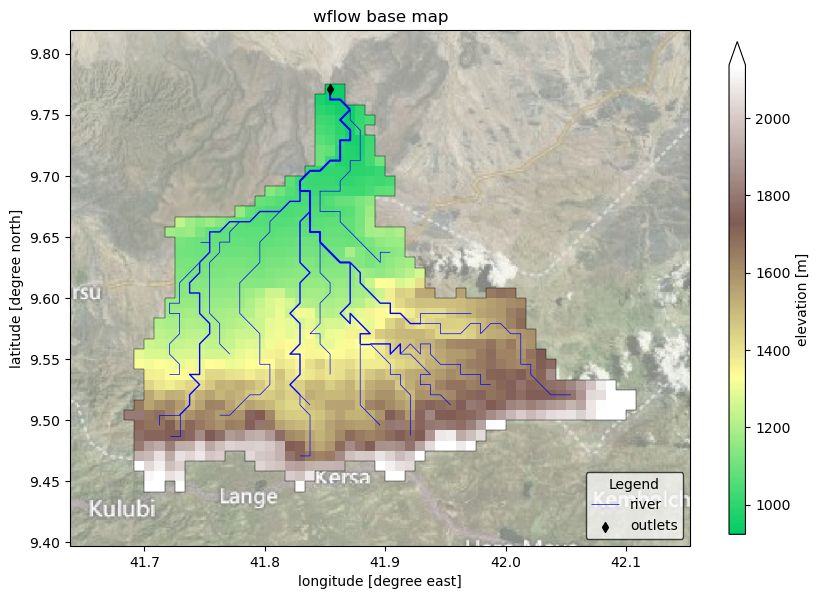

In [7]:
# read and mask the model elevation
da = model.staticmaps.data["land_elevation"].raster.mask_nodata()
da.attrs.update(long_name="elevation", units="m")
# read/derive river geometries
gdf_riv = model.rivers
# read/derive model basin boundary
gdf_bas = model.basins

# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False  # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = da.raster.box.to_crs(3857).buffer(5e3).to_crs(da.raster.crs).total_bounds
extent = np.array(bbox)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot elevation\
# create nice colormap
vmin, vmax = da.quantile([0.0, 0.98]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)
# plot 'normal' elevation
da.plot(
    transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=0.8), **kwargs
)
# plot elevation with shades
if shaded:
    ls = colors.LightSource(azdeg=315, altdeg=45)
    dx, dy = da.raster.res
    _rgb = ls.shade(
        da.fillna(0).values,
        norm=kwargs["norm"],
        cmap=kwargs["cmap"],
        blend_mode="soft",
        dx=dx,
        dy=dy,
        vert_exag=200,
    )
    rgb = xr.DataArray(dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords)
    rgb = xr.where(np.isnan(da), np.nan, rgb)
    rgb.plot.imshow(transform=proj, ax=ax, zorder=2)

# plot rivers with increasing width with stream order
gdf_riv.plot(
    ax=ax, linewidth=gdf_riv["strord"] / 2, color="blue", zorder=3, label="river"
)
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color="k", linewidth=0.3)
# plot various vector layers if present
if "outlets" in model.geoms.data:
    model.geoms.data["outlets"].plot(
        ax=ax, marker="d", markersize=25, facecolor="k", zorder=5, label="outlets"
    )
patches = []  # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if "meta_reservoirs_no_control" in model.geoms.data:
    kwargs = dict(facecolor="lightblue", edgecolor="black", linewidth=1, label="reservoirs (natural lakes)")
    model.geoms.data["meta_reservoirs_no_control"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "meta_reservoirs_simple_control" in model.geoms.data:
    kwargs = dict(facecolor="blue", edgecolor="black", linewidth=1, label="reservoirs (simple control)")
    model.geoms.data["meta_reservoirs_simple_control"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if "glaciers" in model.geoms.data:
    kwargs = dict(facecolor="grey", edgecolor="grey", linewidth=1, label="glaciers")
    model.geoms.data["glaciers"].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)

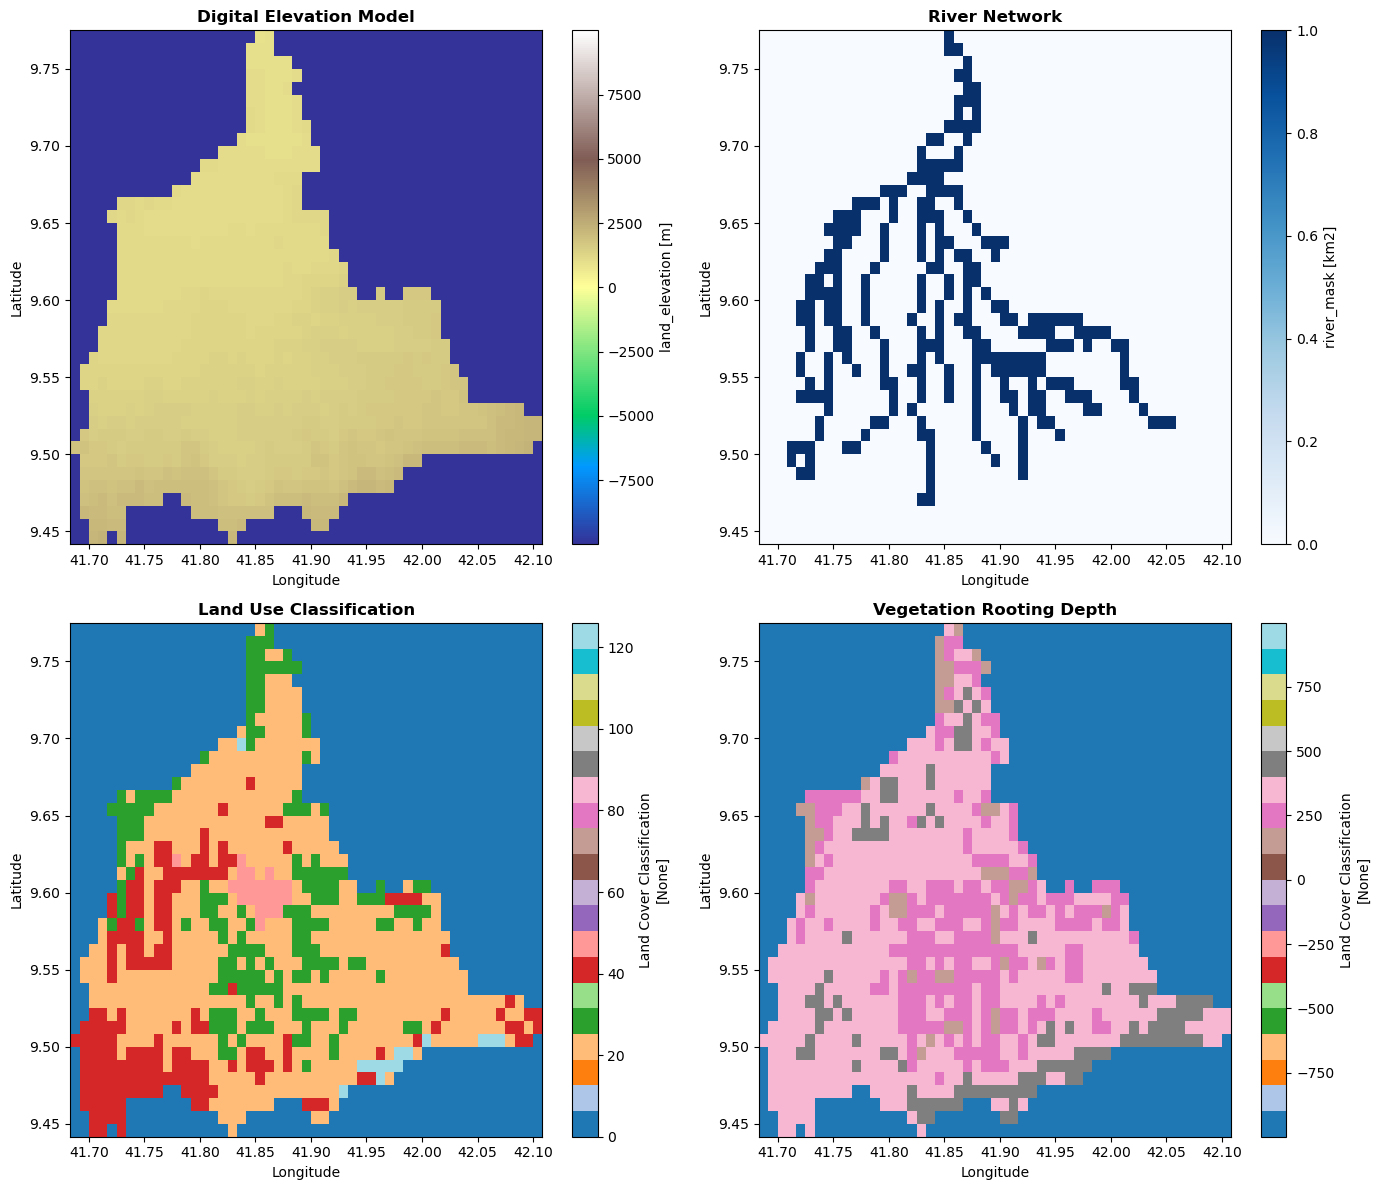

In [8]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Elevation
model.staticmaps.data['land_elevation'].plot(ax=axes[0, 0], cmap='terrain')
axes[0, 0].set_title('Digital Elevation Model', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')

# Plot 2: River network
model.staticmaps.data['river_mask'].plot(ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('River Network', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')

# Plot 3: Land use
model.staticmaps.data['meta_landuse'].plot(ax=axes[1, 0], cmap='tab20')
axes[1, 0].set_title('Land Use Classification', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')

# Plot 4: Land slope
model.staticmaps.data['vegetation_root_depth'].plot(ax=axes[1, 1], cmap='tab20')
axes[1, 1].set_title('Vegetation Rooting Depth', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

Calculate the average forcing accros the watershed:

---

## Part 5: Model Configuration and Settings

### 5.1 Understanding the TOML Configuration

The `wflow_sbm.toml` file controls how the model runs. Let's examine key sections:

In [9]:
# Read and display the first 50 lines of the TOML configuration
# !head -n 50 ./wflow_models/dire_dawa_wflow_model/wflow_sbm.toml

**Key configuration sections**:

#### `[model]`
Defines model type and core settings:
```toml
[model]
type = "sbm"
masswasting = true
snow = false
reinit = true
reservoirs = false
lakes = false
glacier = false
```

#### `[state]`
Specifies initial condition files:
```toml
[state]
path_input = "inmaps/instates.nc"
path_output = "output/outstates.nc"
```

#### `[input]`
Points to static maps and forcing data:
```toml
[input]
path_forcing = "forcing/inmaps.nc"
path_static = "staticmaps/staticmaps.nc"
```

#### `[output]`
Controls what variables to save and at what frequency:
```toml
[output]
path = "output/output.nc"
```

### 5.2 Customizing Output Variables

You can modify which variables are saved by editing the TOML file. Common output variables include:

**Water balance components**:
- `q_river`: River discharge [m³/s]
- `q_land`: Lateral flow [mm/day]
- `actevap`: Actual evapotranspiration [mm/day]
- `snow`: Snow water equivalent [mm]

**Storage variables**:
- `ustorelayerdepth`: Unsaturated zone storage [mm]
- `satwaterdepth`: Saturated zone storage [mm]
- `canopystorage`: Canopy interception storage [mm]

**Fluxes**:
- `infiltration`: Infiltration rate [mm/day]
- `recharge`: Groundwater recharge [mm/day]
- `runoff`: Surface runoff [mm/day]

---

## Part 6: Running the Model

### 6.1 Execute the Wflow Simulation

Now that the model is built and configured, we can run the simulation. Wflow uses the Julia-based Wflow.jl backend for efficient computation.

In [10]:
# Install julia (once!!)

In [11]:
# Run the Wflow model
# Note: This assumes you have Julia and Wflow.jl installed
import subprocess, shlex

cmd = r'julia --color=yes -e "ENV[\"JULIA_SSL_CA_ROOTS_PATH\"]=\"\"; using Wflow; Wflow.run(\"./wflow_models/dire_dawa_wflow_model/wflow_sbm.toml\")"'

process = subprocess.Popen(
    shlex.split(cmd),
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True,
    encoding="utf-8",
    bufsize=1,
)

for line in process.stdout:
    print(line, end="")

process.wait()

[ Info: Wflow version v1.0.0-dev
[ Info: Initialize model variables for model type sbm.
┌ Info: Cyclic parameters are provided by
└ wflow_models\dire_dawa_wflow_model\staticmaps.nc.
┌ Info: Forcing parameters are provided by
└ wflow_models\dire_dawa_wflow_model\era5_hourly.nc.
┌ Info: Set atmosphere_water__precipitation_volume_flux using netCDF variable
└ precip as forcing parameter.
┌ Info: Set atmosphere_air__temperature using netCDF variable temp as forcing
└ parameter.
┌ Info: Set land_surface_water__potential_evaporation_volume_flux using
└ netCDF variable pet as forcing parameter.
┌ Info: Set vegetation__leaf_area_index using netCDF variable
└ vegetation_leaf_area_index as cyclic parameter, with 12 timesteps.
┌ Info: General model settings
│   snow = true
│   gravitational_snow_transport = true
│   glacier = false
│   reservoirs = false
│   pits = false
└   water_demand = false
[ Info: Set subbasin_location__count using netCDF variable subcatchment.
┌ Info: Set basin__local_drain

0

**What happens during the run?**

1. **Initialization**: Model reads configuration and loads static maps
2. **State loading**: Initial conditions are loaded from `inmaps/`
3. **Time loop**: For each timestep:
   - Read forcing data (precipitation, temperature, PET)
   - Compute interception and snow processes
   - Calculate soil moisture dynamics
   - Simulate runoff generation
   - Route water through river network
   - Write outputs at specified frequency
4. **Finalization**: Save final state for future runs

**Runtime**: Depending on:
- Simulation period length
- Grid resolution and catchment size
- Time step (daily, hourly, etc.)
- Computer specifications

Expect 1-30 minutes for typical daily simulations of 1-5 years.

### 6.2 Monitoring Model Progress

During the run, watch for:
- **Water balance errors**: Should be < 0.1% per timestep
- **Convergence issues**: Indicates potential parameter problems
- **Memory usage**: Large models may need optimization
- **Progress updates**: Shows current date being simulated

---

## Part 7: Analyzing Model Results

### 7.1 Load and Inspect Output Files

In [12]:
# Load model outputs
output_file = "./wflow_models/dire_dawa_wflow_model/run_default/output.nc"
ds = xr.open_dataset(output_file)

# Display dataset information
print("Output dataset contents:")
print(ds)
print("\nTime range:")
print(f"Start: {ds.time[0].values}")
print(f"End: {ds.time[-1].values}")
print(f"Total timesteps: {len(ds.time)}")

Output dataset contents:
<xarray.Dataset> Size: 5MB
Dimensions:  (time: 624, lat: 40, lon: 51, layer: 4)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2024-06-01T01:00:00 ... 2024-06-27
  * lat      (lat) float64 320B 9.446 9.454 9.463 9.471 ... 9.754 9.762 9.771
  * lon      (lon) float64 408B 41.69 41.7 41.7 41.71 ... 42.08 42.09 42.1 42.1
  * layer    (layer) float64 32B 1.0 2.0 3.0 4.0
Data variables:
    q_av     (time, lat, lon) float32 5MB ...

Time range:
Start: 2024-06-01T01:00:00.000000000
End: 2024-06-27T00:00:00.000000000
Total timesteps: 624


### 7.2 Visualize Discharge Time Series

Let's plot the simulated discharge at the basin outlet:

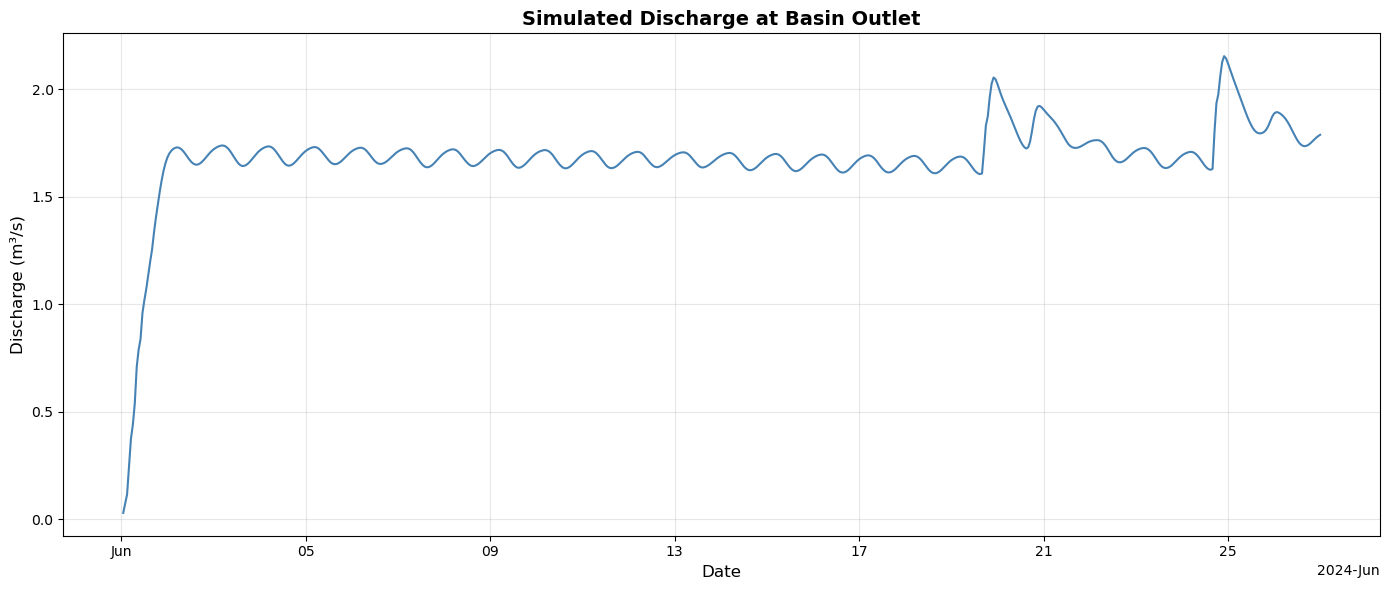

In [13]:
# Extract discharge at the outlet

# Get outlet location (typically where river has maximum upstream area)
discharge = ds['q_av'].max(dim=['lon', 'lat'])  # Adjust dimensions as needed

# Create discharge plot
fig, ax = plt.subplots(figsize=(14, 6))
discharge.plot(ax=ax, linewidth=1.5, color='steelblue')
ax.set_title('Simulated Discharge at Basin Outlet', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Discharge (m³/s)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.3 Spatial Visualization of Model Results

Create spatial maps of outputs:

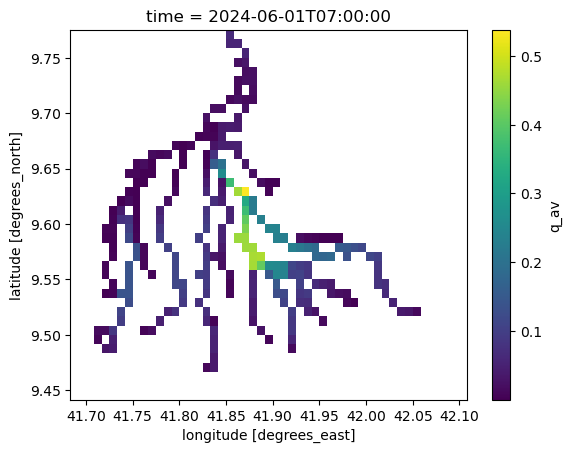

In [14]:
ds['q_av'].isel(time=6).plot()

---

## Part 8: Best Practices and Troubleshooting

### 8.1 Common Issues and Solutions

**Problem**: Model build fails with "No data found for region"
- **Solution**: Check your region coordinates are correct (lon, lat order)
- Verify data catalog has coverage for your area
- Try a slightly larger bounding box

**Problem**: Very high or low discharge values
- **Solution**: Check forcing data units (mm/day vs mm/hour)
- Verify DEM and river network are realistic
- Inspect parameter maps for outliers

**Problem**: Model runs slowly
- **Solution**: Reduce grid resolution in build configuration
- Use coarser timestep if appropriate
- Limit output variables to essentials

**Problem**: Large water balance errors
- **Solution**: Check for missing or corrupted forcing data
- Verify static maps have no missing values
- Review numerical stability settings

### 8.2 Quality Control Checklist

Before running your model, verify:
- ✓ DEM has no sinks or anomalies
- ✓ River network matches expected topology
- ✓ Land use classes are reasonable
- ✓ Soil parameters within physical ranges
- ✓ Forcing data covers simulation period
- ✓ No missing values in critical maps
- ✓ Output directory has write permissions

### 8.3 Performance Optimization Tips

1. **Grid resolution**: Start coarse (500m-1km), refine if needed
2. **Timestep**: Use daily timestep unless sub-daily processes are critical
3. **Output frequency**: Write only what you need for analysis
4. **Spatial extent**: Model only the catchment of interest
5. **Warmup period**: Use 1-2 years to initialize states properly

---

## Summary and Next Steps

### What We've Learned

In this tutorial, you've learned the complete workflow for building and running your first Wflow model:
1. ✓ Set up and verify HydroMT installation
2. ✓ Build a complete Wflow model from scratch using example data
3. ✓ Visualize model components (topography, rivers, land use)
4. ✓ Understand model structure and key files
5. ✓ Run hydrological simulations
6. ✓ Analyze and visualize model outputs

### Additional Resources

**Documentation**:
- HydroMT docs: https://deltares.github.io/hydromt/
- HydroMT-Wflow plugin: https://deltares.github.io/hydromt_wflow/
- Wflow documentation: https://deltares.github.io/Wflow.jl/

**Community**:
- GitHub discussions: https://github.com/Deltares/hydromt/discussions
- Issue tracker: https://github.com/Deltares/hydromt_wflow/issues

---